## Settings

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

## Data

In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

## Bins

Nestas células fazemos um recorte de intervalos de z de largura 0.05 e esses intervalos são colocados em **halos_bin_z**. Depois, pegamos cada *bin* em z e cortamos em intervalos de lnM de largura 0.25. Os bins são colocados em **halos_bin_mz**.

Para cada intervalo em **halos_bin_mz** é calculado lnR médio, z médio e lnM médio e as listas desses valores são colocadas na tabela **halos mean**.

In [3]:
# redshift bins
z_0 = 0.0
z_1 = 0.05
halos_bin_z =[]

for i in range(60):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.05
    z_1 = z_1 + 0.05

# mass bins
label = []
halos_bin_mz =[]
for i in range(60):
    
    lnM_0 = min(lnM)
    lnM_1 = min(lnM) + 0.25
    for j in range(18):
        
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")
        
        lnM_0 = lnM_0 + 0.25
        lnM_1 = lnM_1 + 0.25

In [4]:
lnM_binned, z_binned, lnR_binned = [], [], []

for i in range(len(halos_bin_mz)):
    
    halos = halos_bin_mz[i]
    lnM_binned.append(np.log(halos["m200c"]))
    z_binned.append(halos["redshift_true"])
    lnR_binned.append(np.log(halos["richness"]))   

lnR_mean, lnM_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 0], [np.mean(l) for l in lnM_binned if len(l) > 0], [np.mean(k) for k in z_binned if len(k) > 0]

halos_mean = Table([np.exp(np.array(lnR_mean)), np.exp(np.array(lnM_mean)), z_mean],
           names=('richness', 'm200c', 'redshift_true'))

In [5]:
# fig = plt.figure(figsize=(16,4))

# ax1 = fig.add_subplot(1,3,1, projection='3d')
# ax2 = fig.add_subplot(1,3,2)
# ax3 = fig.add_subplot(1,3,3)

# zs = lnR_mean
# xs = z_mean
# ys = lnM_mean

# p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
# ax1.set_xlabel('z')
# ax1.set_ylabel('lnM')
# #ax1.set_zlabel('mu0')
# fig.colorbar(p3, ax=ax1, label='LnR mean')

# p4 = ax2.scatter(ys, zs , c= xs, cmap='RdYlBu')
# ax2.set_xlabel('lnM')
# ax2.set_ylabel('LnR mean')
# fig.colorbar(p4, ax=ax2, label='z')

# p5 = ax3.scatter(xs, zs , c=ys, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
# ax3.set_xlabel('z')
# ax3.set_ylabel('LnR mean')
# fig.colorbar(p5, ax=ax3, label='lnM')

# plt.show()

## Ascaso Fit Params

Aqui fazemos o ajuste do modelo de ascaso e encontramos os valores dos parâmetros usando todos os dados em **dt_halos** (sem dividir em intervalos). 

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$



In [6]:
dt_halos = Table(DC2_halos_m200c[1].data)
rmdata = create_richness_mass_calib(dt_halos)
ascaso = Nc.ClusterMassAscaso()
ascaso.param_set_by_name("cut", 1e15)

mset = Ncm.MSet()
mset.set(ascaso)

rmdata.m2lnL_val(mset)

13028468.257429378

In [7]:
dset = Ncm.Dataset.new()
dset.append_data(rmdata)

lh = Ncm.Likelihood.new(dset)

mset.param_set_all_ftype(Ncm.ParamType.FREE)
mset.param_set_ftype(7000, 6, Ncm.ParamType.FIXED)

mset.prepare_fparam_map()

fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )

In [8]:
fit.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1e+15               [FIXED]


In [9]:
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#...............................................................................................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:24.5640680
#  iteration            [001028]
#  function evaluations [001030]
#  gradient evaluations [000000]
#  degrees of freedom   [454469]
#  m2lnL     =     186132.595095027 (      186132.6 )
#  Fit parameters:
#     4.08771155304458     0.538112851881662    0.931352200237261    0.674669446785109    0.0644918258598748  -0.244466020858333   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 12842335.6623344      
#  - relative improvement: 0.9857133938

In [10]:
fit.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  4.45400088393851    [FREE]
#   -    mup1[01]:  0.688636815620556   [FREE]
#   -    mup2[02]:  1.23729998567613    [FREE]
#   - sigmap0[03]:  0.22719831747665    [FREE]
#   - sigmap1[04]: -0.0513997966262962  [FREE]
#   - sigmap2[05]: -0.125434360872823   [FREE]
#   -     cut[06]:  1e+15               [FIXED]


In [11]:
lnR_mean_ascaso = np.array([ascaso.get_mean_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
lnR_std_ascaso = np.array( [ascaso.get_std_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])

## Ext Fit Params

Aqui fazemos o ajuste do modelo extendido, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [12]:
rmdata = create_richness_mass_calib(dt_halos)

ext = Nc.ClusterMassLnrichExt()
ext.param_set_by_name("cut", 1e15)

mset = Ncm.MSet()
mset.set(ext)

rmdata.m2lnL_val(mset)

dset = Ncm.Dataset.new()
dset.append_data(rmdata)

lh = Ncm.Likelihood.new(dset)

mset.param_set_all_ftype(Ncm.ParamType.FREE)
mset.param_set_ftype(7000, 12, Ncm.ParamType.FIXED)
mset.param_set_ftype(7000, 13, Ncm.ParamType.FIXED)
mset.param_set_ftype(7000, 14, Ncm.ParamType.FIXED)


mset.prepare_fparam_map()

fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )

fit.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -     cut[12]:  1e+15               [FIX

In [13]:
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#...........................................................................................................................................................................................................................................................................................................................................................................................................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:02:13.9446250
#  iteration            [004022]
#  function evaluations [004024]
#  gradient evaluations [000000]
#  degrees of freedom   [454463]
#  m2lnL     =     151602.026727572 (     151602.03 )
#  Fit parameters:
#     4.99116587174189     0.9992611

In [14]:
fit.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  4.60525907398996    [FREE]
#   -    muM1[01]:  0.872574501280655   [FREE]
#   -    muZ1[02]:  1.77372685264065    [FREE]
#   -    muM2[03]:  0.0418554944174375  [FREE]
#   -    muZ2[04]: -0.140632257475756   [FREE]
#   -    muMZ[05]:  0.142070575253928   [FREE]
#   -  sigma0[06]:  0.288751383460722   [FREE]
#   - sigmaM1[07]:  0.0172421525557671  [FREE]
#   - sigmaZ1[08]: -0.0164925362018258  [FREE]
#   - sigmaM2[09]:  0.0152877453813611  [FREE]
#   - sigmaZ2[10]:  0.00851390090247082 [FREE]
#   - sigmaMZ[11]:  0.0376940926517597  [FREE]
#   -     cut[12]:  1e+15               [FIX

In [15]:
lnR_mean_ext = np.array([ext.get_mean_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
lnR_std_ext = np.array( [ext.get_std_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])

## Comparison I

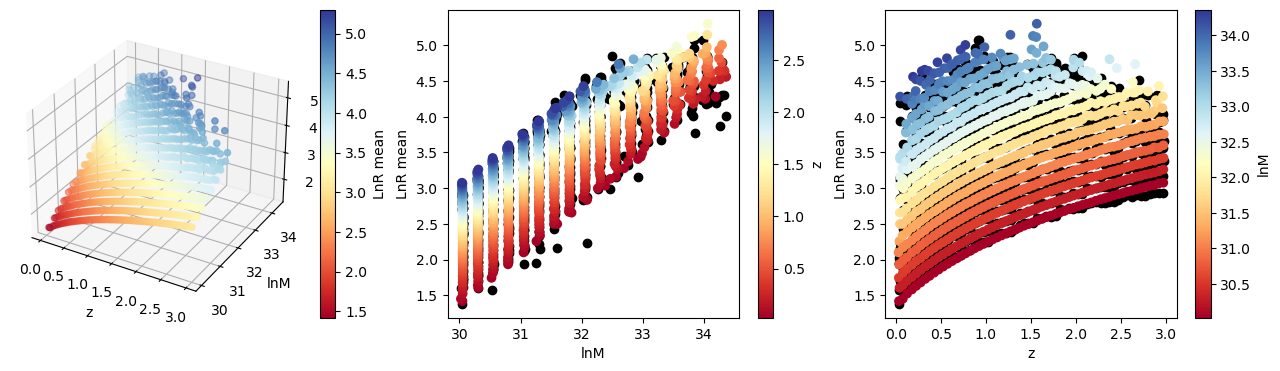

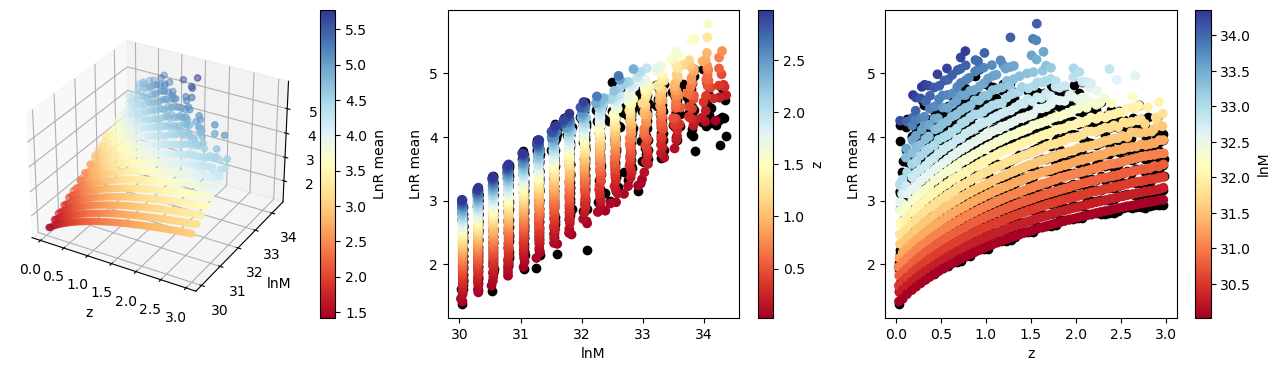

In [16]:
#### Ascaso ####

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

zs = lnR_mean_ascaso
xs = z_mean
ys = lnM_mean

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
ax1.set_xlabel('z')
ax1.set_ylabel('lnM')
#ax1.set_zlabel('mu0')
fig.colorbar(p3, ax=ax1, label='LnR mean')

#data comparison
dc_lnR = [np.mean(j) for j in lnR_binned if len(j)>0]
dc_z = [np.mean(k) for k in z_binned if len(k) > 0]
dc_lnM = [np.mean(l) for l in lnM_binned if len(l) > 0]


ax2.scatter(dc_lnM, dc_lnR, c='k')
p4 = ax2.scatter(ys, zs , c= xs, cmap='RdYlBu')
ax2.set_xlabel('lnM')
ax2.set_ylabel('LnR mean')
fig.colorbar(p4, ax=ax2, label='z')

ax3.scatter(dc_z, dc_lnR, c='k')
p5 = ax3.scatter(xs, zs , c=ys, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax3.set_xlabel('z')
ax3.set_ylabel('LnR mean')
fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()


#### Extended ####

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

zs = lnR_mean_ext
xs = z_mean
ys = lnM_mean

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
ax1.set_xlabel('z')
ax1.set_ylabel('lnM')
#ax1.set_zlabel('mu0')
fig.colorbar(p3, ax=ax1, label='LnR mean')

#data comparison
dc_lnR = [np.mean(j) for j in lnR_binned if len(j)>0]
dc_z = [np.mean(k) for k in z_binned if len(k) > 0]
dc_lnM = [np.mean(l) for l in lnM_binned if len(l) > 0]

ax2.scatter(dc_lnM, dc_lnR, c='k')
p4 = ax2.scatter(ys, zs , c= xs, cmap='RdYlBu')
ax2.set_xlabel('lnM')
ax2.set_ylabel('LnR mean')
fig.colorbar(p4, ax=ax2, label='z')

ax3.scatter(dc_z, dc_lnR, c='k')
p5 = ax3.scatter(xs, zs , c=ys, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax3.set_xlabel('z')
ax3.set_ylabel('LnR mean')
fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()

In [17]:
dt_halos = Table(DC2_halos_m200c[1].data)

# lnM = np.array(np.log(dt_halos["m200c"]))  # ln(mass)
# z = np.array(dt_halos["redshift_true"])  # redshift
lnR = np.array(np.log(dt_halos["richness"]))  # ln(richness)

mean_ext = [ext.get_mean_richness(i, j) for i, j in zip(lnM, z)]
std_ext = [ext.get_std_richness(i, j) for i, j in zip(lnM, z)]

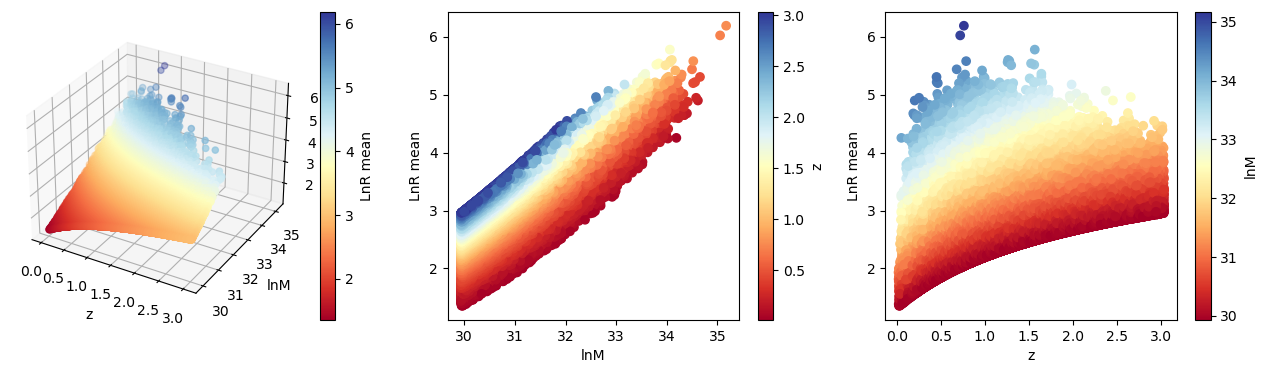

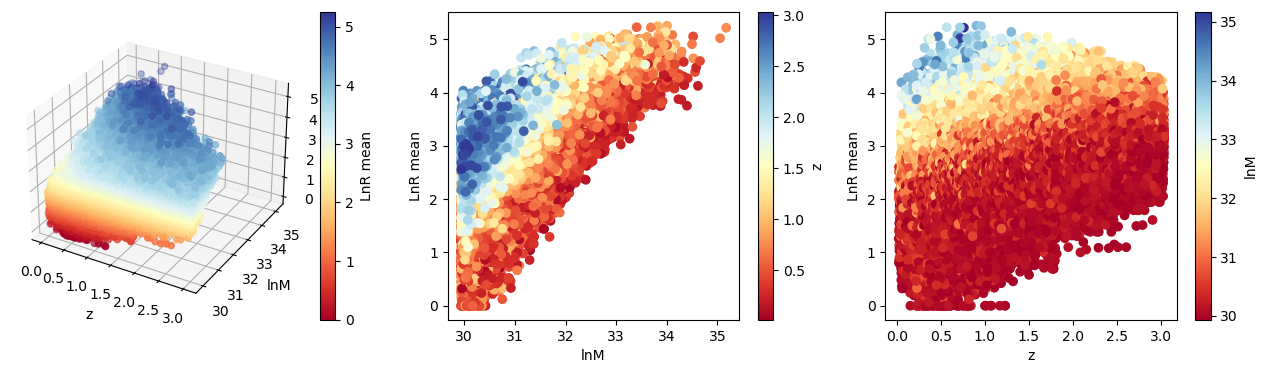

In [18]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

zs = mean_ext
xs = z
ys = lnM

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
ax1.set_xlabel('z')
ax1.set_ylabel('lnM')
#ax1.set_zlabel('mu0')
fig.colorbar(p3, ax=ax1, label='LnR mean')

p4 = ax2.scatter(ys, zs , c= xs, cmap='RdYlBu')
ax2.set_xlabel('lnM')
ax2.set_ylabel('LnR mean')
fig.colorbar(p4, ax=ax2, label='z')

p5 = ax3.scatter(xs, zs , c=ys, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax3.set_xlabel('z')
ax3.set_ylabel('LnR mean')
fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

zs = lnR

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
ax1.set_xlabel('z')
ax1.set_ylabel('lnM')
#ax1.set_zlabel('mu0')
fig.colorbar(p3, ax=ax1, label='LnR mean')

p4 = ax2.scatter(ys, zs , c= xs, cmap='RdYlBu')
ax2.set_xlabel('lnM')
ax2.set_ylabel('LnR mean')
fig.colorbar(p4, ax=ax2, label='z')

p5 = ax3.scatter(xs, zs , c=ys, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax3.set_xlabel('z')
ax3.set_ylabel('LnR mean')
fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()

/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


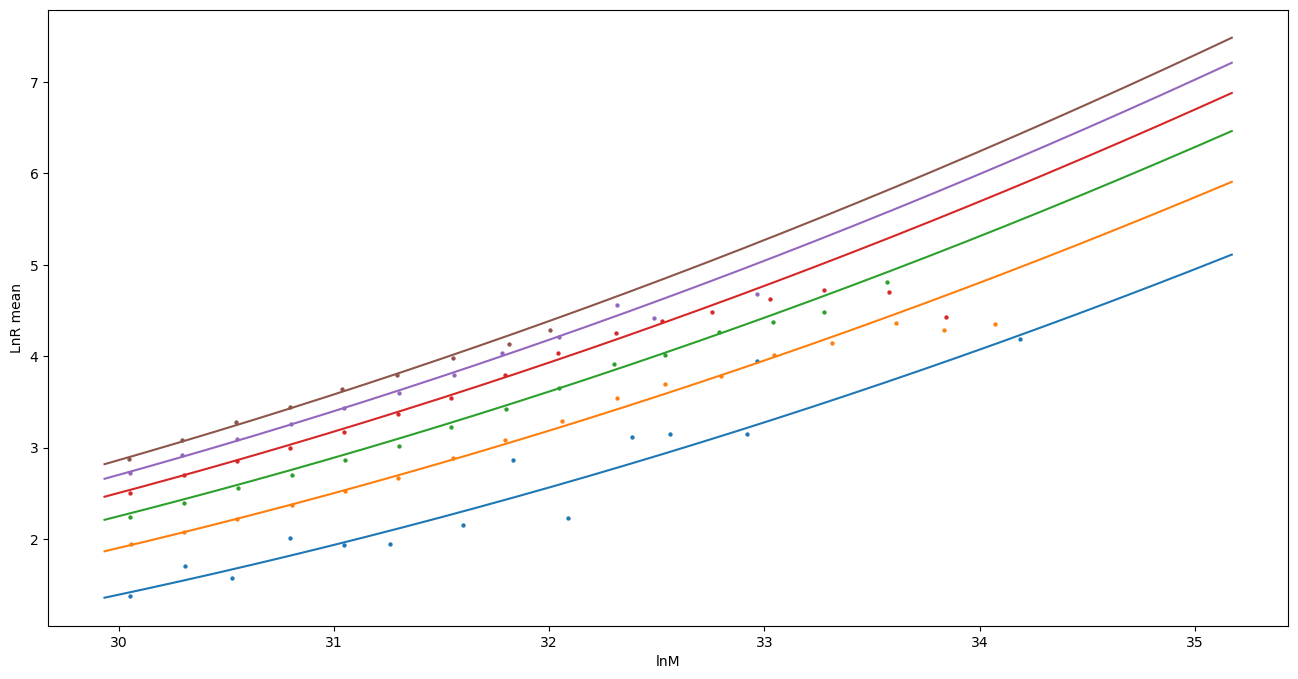

In [19]:
fig = plt.figure(figsize=(16,8))

# ax1 = fig.add_subplot(1,3,1, projection='3d')
# ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,1,1)

zs = mean_ext
xs = z
ys = lnM


#p5 = ax3.scatter(xs, zs , c=ys, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados

z_a = np.linspace(np.min(z), np.max(z), 10)
lnM_a = np.linspace(np.min(lnM), np.max(lnM), 1000)

for j in range(0, 60, 10):
    z_j = np.mean(z_binned[j * 18])
    
    ax3.plot(lnM_a, [ext.get_mean_richness(lnM_i, z_j) for lnM_i in lnM_a])
    t1 = [np.mean(lnM_binned[j * 18 + i ]) for i in range(18)]
    t2 = [np.mean(lnR_binned[j * 18 + i ]) for i in range(18)]
    
    ax3.scatter(t1, t2, s=4.5)

#p5 = ax3.scatter(lnM_mean, lnR_mean , c=z_mean, cmap='RdYlBu', s=0.4)
ax3.set_xlabel('lnM')
ax3.set_ylabel('LnR mean')
#fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()


## Comparison II

NameError: name 'ln' is not defined

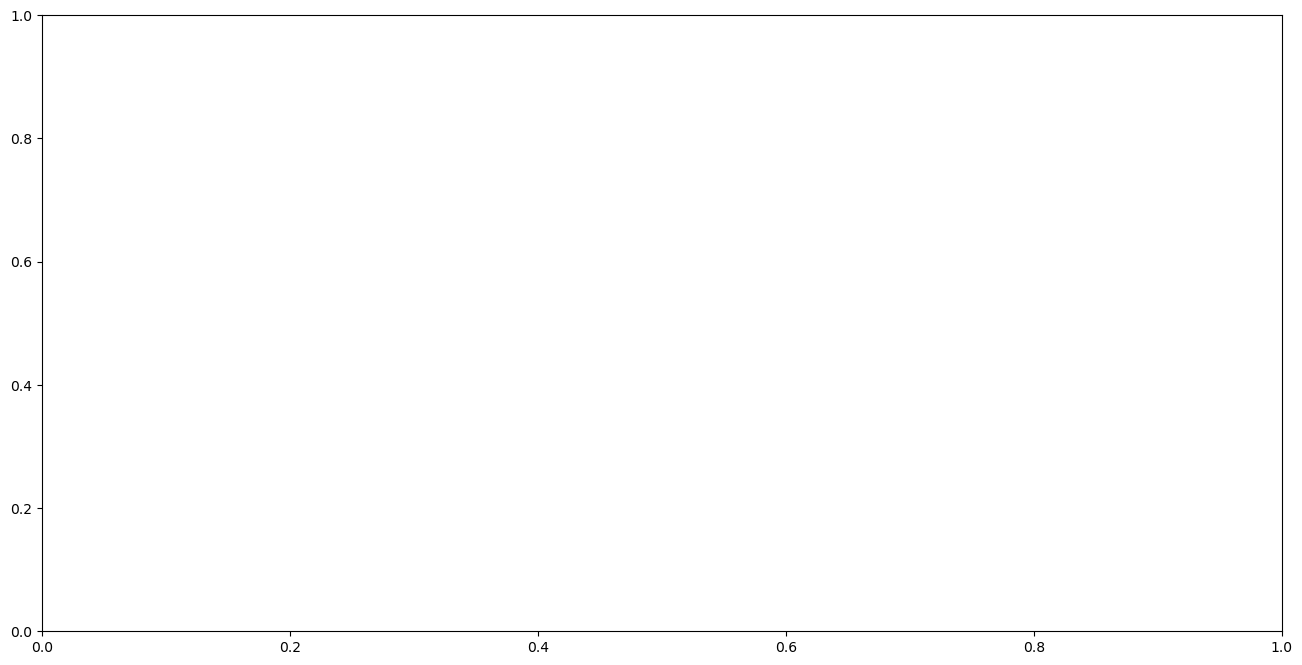

In [20]:
fig = plt.figure(figsize=(16,8))

# ax1 = fig.add_subplot(1,3,1, projection='3d')
# ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,1,1)

#p5 = ax3.scatter(xs, zs , c=ys, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados

z_a = np.linspace(np.min(z), np.max(z), 6)
lnM_a = np.linspace(np.min(lnM), np.max(lnM), 1000)

for j in range(0, 60, 6):
    z_j = np.mean(z_binned[j * 18])
    
    ax3.plot(lnM_a, [ascaso.get_std_richness(lnM_i, z_j) for lnM_i in lnM_a])
    t1 = [np.mean(lnM_binned[j * 18 + i ]) for i in range(18)]
    t2 = [np.std(lnR_binned[j * 18 + i ]) for i in range(18)]
    
    ax3.scatter(t1, t2, s=4.5)

#p5 = ax3.scatter(lnM_mean, lnR_mean , c=z_mean, cmap='RdYlBu', s=0.4)
ax3.set_xlabel('lnM')
ax3.set_ylabel('LnR std')
#fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()
